In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [110]:
import warnings
warnings.filterwarnings("ignore")

In [111]:
df = pd.read_csv("./House_Rent_Dataset.csv")

In [112]:
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,5/18/2022,2,10000.0,1100.0,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2.0,Contact Owner
1,5/13/2022,2,20000.0,NaN,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1.0,Contact Owner
2,5/16/2022,2,17000.0,1000.0,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1.0,Contact Owner
3,7/4/2022,2,10000.0,NaN,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1.0,Contact Owner
4,5/9/2022,2,7500.0,850.0,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1.0,Contact Owner


In [113]:
df.drop(columns=["Posted On", "Area Locality"], inplace=True)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BHK                4746 non-null   int64  
 1   Rent               4741 non-null   float64
 2   Size               4738 non-null   float64
 3   Floor              4746 non-null   object 
 4   Area Type          4739 non-null   object 
 5   City               4746 non-null   object 
 6   Furnishing Status  4746 non-null   object 
 7   Tenant Preferred   4746 non-null   object 
 8   Bathroom           4742 non-null   float64
 9   Point of Contact   4746 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 370.9+ KB


In [115]:
df.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.741000e+03,4738.000000,4742.000000
mean,2.083860,3.502340e+04,967.936049,1.965837
std,0.832256,7.814214e+04,634.562635,0.884904
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


In [116]:
df.isnull().sum()

BHK                  0
Rent                 5
Size                 8
Floor                0
Area Type            7
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             4
Point of Contact     0
dtype: int64

In [117]:
df.dropna(inplace=True)

In [118]:
print("Number of duplicate rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

Number of duplicate rows: 40


In [119]:
print("Number of null values in each column:", df.isnull().sum().sum())
print("Number of duplicate rows:", df.duplicated().sum())

Number of null values in each column: 0
Number of duplicate rows: 0


In [120]:
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
print("Length of numerical columns:", len(num_cols))
print("Numerical columns:", num_cols)

Length of numerical columns: 4
Numerical columns: ['BHK', 'Rent', 'Size', 'Bathroom']


In [121]:
def cap_outliers_iqr(df, cols):
    df_capped = df.copy()
    for col in cols:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_capped[col] = df_capped[col].apply(
            lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
        )
    return df_capped

In [122]:
df = cap_outliers_iqr(df, num_cols)

print(df.describe())

               BHK          Rent         Size     Bathroom
count  4686.000000   4686.000000  4686.000000  4686.000000
mean      2.082053  24674.311353   933.925416     1.924242
std       0.816087  19949.151318   508.414594     0.756418
min       1.000000   1200.000000    10.000000     1.000000
25%       2.000000  10000.000000   555.750000     1.000000
50%       2.000000  16000.000000   850.000000     2.000000
75%       3.000000  33000.000000  1200.000000     2.000000
max       4.500000  67500.000000  2166.375000     3.500000


In [123]:
import os

save_path = "images"
os.makedirs(save_path, exist_ok=True)

def save_figure(fig, filename):
    fig.write_image(os.path.join(save_path, filename), format="png")

In [124]:
# 1. Histogram: Rent Distribution
fig_rent_dist = px.histogram(
    df,
    x="Rent",
    nbins=50,
    marginal="box",
    title="Distribution of Rent",
    template="plotly_white"
)
fig_rent_dist.show()
save_figure(fig_rent_dist, "rent_distribution.png")

In [125]:
# 2. Scatter Plot: Size vs Rent
fig = px.scatter(
    df,
    x="Size",
    y="Rent",
    opacity=0.7,
    title="Rent vs Size",
    template="plotly_white",
    labels={"Size": "Property Size (sq ft)", "Rent": "Monthly Rent"}
)
fig.show()
save_figure(fig, "rent_vs_size.png")

In [126]:
# 3. Box Plot: Rent by City
fig = px.box(
    df,
    x="City",
    y="Rent",
    title="Rent by City",
    template="plotly_white"
)
fig.show()
save_figure(fig, "rent_by_city.png")

In [127]:
# 4. Box Plot: Rent by Furnishing
fig = px.box(
    df,
    x="Furnishing Status",
    y="Rent",
    title="Rent by Furnishing Status",
    template="plotly_white"
)
fig.show()
save_figure(fig, "rent_by_furnishing.png")

In [128]:
# 5. Box Plot: Rent by Bedrooms
fig = px.box(
    df,
    x="BHK",
    y="Rent",
    title="Rent by Number of Bedrooms (BHK)",
    template="plotly_white"
)
fig.show()
save_figure(fig, "rent_by_bhk.png")

In [129]:
# 6. Box Plot: Rent by Bathrooms
fig = px.box(
    df,
    x="Bathroom",
    y="Rent",
    title="Rent by Number of Bathrooms",
    template="plotly_white"
)
fig.show()
save_figure(fig, "rent_by_bathroom.png")

In [130]:
# 7. Box Plot: Rent by Tenant Type
fig = px.box(
    df,
    x="Tenant Preferred",
    y="Rent",
    title="Rent by Tenant Type",
    template="plotly_white"
)
fig.show()
save_figure(fig, "rent_by_tenant_type.png")

In [131]:
# 8. Bar Plot: Listings per City
city_counts = df["City"].value_counts().reset_index()
city_counts.columns = ["City", "Count"]

fig = px.bar(
    city_counts,
    x="Count",
    y="City",
    orientation="h",
    title="Number of Listings per City",
    template="plotly_white"
)
fig.show()
save_figure(fig, "listings_per_city.png")

In [132]:
# 9. Pie Chart: Furnishing Status
fig = px.pie(
    df,
    names="Furnishing Status",
    title="Furnishing Status Distribution"
)
fig.show()
save_figure(fig, "furnishing_pie-chart.png")

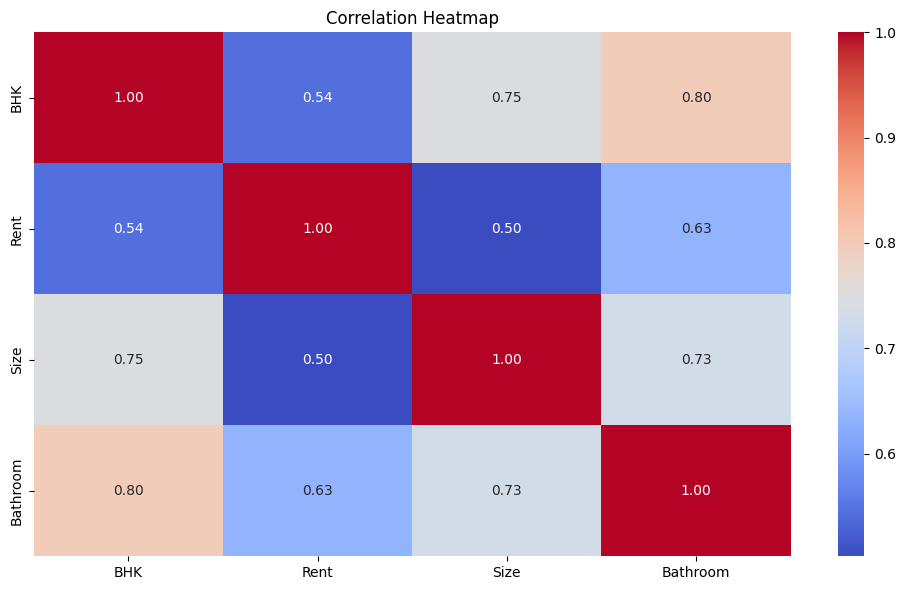

In [133]:
# 10. Correlation Heatmap
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(f"{save_path}/correlation_heatmap.png")

In [134]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Length of categorical columns:", len(cat_cols))
print("Categorical columns:", cat_cols)

Length of categorical columns: 6
Categorical columns: ['Floor', 'Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']


In [135]:
for col in cat_cols[:3]:
  print(df[col].value_counts())

Floor
1 out of 2         370
Ground out of 2    336
2 out of 3         310
2 out of 4         302
1 out of 3         289
                  ... 
1 out of 11          1
6 out of 29          1
28 out of 31         1
1 out of 15          1
2 out of 11          1
Name: count, Length: 480, dtype: int64
Area Type
Super Area     2414
Carpet Area    2270
Built Area        2
Name: count, dtype: int64
City
Mumbai       968
Chennai      880
Bangalore    874
Hyderabad    864
Delhi        599
Kolkata      501
Name: count, dtype: int64


In [136]:
for col in cat_cols[3:6]:
  print(df[col].value_counts())

Furnishing Status
Semi-Furnished    2228
Unfurnished       1786
Furnished          672
Name: count, dtype: int64
Tenant Preferred
Bachelors/Family    3397
Bachelors            819
Family               470
Name: count, dtype: int64
Point of Contact
Contact Owner      3173
Contact Agent      1512
Contact Builder       1
Name: count, dtype: int64


In [137]:
# Split and clean both parts
split_floor = df["Floor"].str.split("out of", expand=True)

# Strip whitespace from both columns
split_floor[0] = split_floor[0].fillna("").str.strip()
split_floor[1] = split_floor[1].fillna("").str.strip()

In [138]:
split_floor[0] = split_floor[0].replace({
    "Ground": "0",
    "Upper Basement": "-1",
    "Basement": "-2",
    "Lower Basement": "-3"
})

In [139]:
df["Current Floor"] = pd.to_numeric(split_floor[0], errors="coerce").astype("Int64")
df["Total Floors"] = pd.to_numeric(split_floor[1], errors="coerce").astype("Int64")

In [140]:
df.dropna(inplace=True)
df.drop(columns=["Floor"], inplace=True)

In [141]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Length of categorical columns:", len(cat_cols))
print("Categorical columns:", cat_cols)

Length of categorical columns: 5
Categorical columns: ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']


In [142]:
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [143]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4682 entries, 0 to 4745
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   BHK                                4682 non-null   float64
 1   Rent                               4682 non-null   float64
 2   Size                               4682 non-null   float64
 3   Bathroom                           4682 non-null   float64
 4   Current Floor                      4682 non-null   Int64  
 5   Total Floors                       4682 non-null   Int64  
 6   Area Type_Carpet Area              4682 non-null   bool   
 7   Area Type_Super Area               4682 non-null   bool   
 8   City_Chennai                       4682 non-null   bool   
 9   City_Delhi                         4682 non-null   bool   
 10  City_Hyderabad                     4682 non-null   bool   
 11  City_Kolkata                       4682 non-null   bool   
 1

In [144]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.base import clone

In [145]:
df_encoded.head()

,BHK,Rent,Size,Bathroom,Current Floor,Total Floors,Area Type_Carpet Area,Area Type_Super Area,City_Chennai,City_Delhi,City_Hyderabad,City_Kolkata,City_Mumbai,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Builder,Point of Contact_Contact Owner
0,2.0,10000.0,1100.0,2.0,0,2,False,True,False,False,False,True,False,False,True,True,False,False,True
2,2.0,17000.0,1000.0,1.0,1,3,False,True,False,False,False,True,False,True,False,True,False,False,True
4,2.0,7500.0,850.0,1.0,1,2,True,False,False,False,False,True,False,False,True,False,False,False,True
5,2.0,7000.0,600.0,2.0,0,1,False,True,False,False,False,True,False,False,True,True,False,False,True
6,2.0,10000.0,700.0,2.0,0,4,False,True,False,False,False,True,False,False,True,False,False,False,False


In [146]:
scaler = StandardScaler()
numerical_cols = ["BHK", "Size", "Bathroom", "Current Floor", "Total Floors"]
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

In [147]:
X = df_encoded.drop("Rent", axis=1)
y = df_encoded["Rent"]

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
model_results = {}

In [150]:
# Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

model_results["LinearRegression"] = {"R2": r2, "MSE": mse}
print(f"🔹 Linear Regression 🔹\nR2 Score: {r2:.4f}\nMSE: {mse:.2f}")

🔹 Linear Regression 🔹
R2 Score: 0.7861
MSE: 93239157.82


In [151]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train R2 Score:", r2_score(y_train, y_train_pred))
print("Test R2 Score:", r2_score(y_test, y_test_pred))

Train R2 Score: 0.7796790549441979
Test R2 Score: 0.7860553276097247


In [152]:
# SVR Regression
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

model_results["SVR"] = {"R2": r2, "MSE": mse}
print(f"🔹 SVR 🔹\nR2 Score: {r2:.4f}\nMSE: {mse:.2f}")

🔹 SVR 🔹
R2 Score: -0.1832
MSE: 515658518.12


In [153]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train R2 Score:", r2_score(y_train, y_train_pred))
print("Test R2 Score:", r2_score(y_test, y_test_pred))

Train R2 Score: -0.16431390599238282
Test R2 Score: -0.18321953248072242


In [154]:
# KNN Regression
model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

model_results["KNN"] = {"R2": r2, "MSE": mse}
print(f"🔹 KNN 🔹\nR2 Score: {r2:.4f}\nMSE: {mse:.2f}")


🔹 KNN 🔹
R2 Score: 0.8102
MSE: 82717233.09


In [155]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train R2 Score:", r2_score(y_train, y_train_pred))
print("Test R2 Score:", r2_score(y_test, y_test_pred))

Train R2 Score: 0.8604901649910058
Test R2 Score: 0.8101987217707172


In [156]:
# Decision Tree Regression
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

model_results["DecisionTree"] = {"R2": r2, "MSE": mse}
print(f"🔹 Decision Tree 🔹\nR2 Score: {r2:.4f}\nMSE: {mse:.2f}")


🔹 Decision Tree 🔹
R2 Score: 0.6820
MSE: 138595844.45


In [157]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train R2 Score:", r2_score(y_train, y_train_pred))
print("Test R2 Score:", r2_score(y_test, y_test_pred))

Train R2 Score: 0.9978941712538035
Test R2 Score: 0.681980798323714


In [158]:
# Random Forest Regression
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

model_results["RandomForest"] = {"R2": r2, "MSE": mse}
print(f"🔹 Random Forest 🔹\nR2 Score: {r2:.4f}\nMSE: {mse:.2f}")


🔹 Random Forest 🔹
R2 Score: 0.8489
MSE: 65868071.25


In [159]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train R2 Score:", r2_score(y_train, y_train_pred))
print("Test R2 Score:", r2_score(y_test, y_test_pred))

Train R2 Score: 0.9733394261121974
Test R2 Score: 0.8488604653462813


In [160]:
print("🔸 Compare all models:")
results_df = pd.DataFrame(model_results).T
print(results_df)

🔸 Compare all models:
                        R2           MSE
LinearRegression  0.786055  9.323916e+07
SVR              -0.183220  5.156585e+08
KNN               0.810199  8.271723e+07
DecisionTree      0.681981  1.385958e+08
RandomForest      0.848860  6.586807e+07


In [161]:
def regression_analysis(X_train, y_train, X_test, y_test):
    # Define scalers
    scalers = {
        "StandardScaler": StandardScaler(),
        "MinMaxScaler": MinMaxScaler(),
        "RobustScaler": RobustScaler()
    }

    # Define models
    base_models = {
        "LinearRegression": LinearRegression(),
        "SVM Regression": SVR(),
        "KNN Regression": KNeighborsRegressor(),
        "DecisionTree": DecisionTreeRegressor(),
        "RandomForest": RandomForestRegressor(),
    }

    # Ensemble models
    ensemble_models = {
        "Voting": VotingRegressor([("lr", LinearRegression()), ("dt", DecisionTreeRegressor()), ("rf", RandomForestRegressor())]),
        "Bagging": BaggingRegressor(RandomForestRegressor(), n_estimators=50),
        "Boosting": GradientBoostingRegressor(n_estimators=100),
        "Stacking": StackingRegressor(estimators=[
            ("lr", LinearRegression()),
            ("svm", SVR()),
            ("rf", RandomForestRegressor())
        ], final_estimator=LinearRegression()),
    }

    models_with_params = {**base_models, **ensemble_models}

    param_grid_all = {
        "Linear Regression": {},
        "SVM Regression": {
            "model__C": [0.1, 1, 10],
            "model__kernel": ["rbf"],
            "model__epsilon": [0.05, 0.1]
        },

        "KNN Regression": {
            "model__n_neighbors": [7, 9],
            "model__weights": ["distance"],
            "model__p": [2]
        },

        "DecisionTree": {
            "model__max_depth": [3, 5, 7],
            "model__min_samples_split": [5, 10],
            "model__min_samples_leaf": [3, 5]
        },

        "RandomForest": {
            "model__n_estimators": [100],
            "model__max_depth": [None, 6],
            "model__min_samples_split": [5],
            "model__min_samples_leaf": [2, 5]
        },

        "Voting": {},
        "Bagging": {
            "model__n_estimators": [100],
            "model__max_samples": [0.8],
            "model__max_features": [0.8]
        },

        "Boosting": {
            "model__n_estimators": [100, 150],
            "model__learning_rate": [0.05],
            "model__max_depth": [3]
        },
        "Stacking": {},
    }


    feature_selector = SelectKBest(score_func=f_regression, k='all')
    models_need_y_scaling = ["SVM Regression", "KNN Regression"]

    results = []

    for scaler_name, scaler in scalers.items():
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for model_name, model in models_with_params.items():
            pipe = Pipeline([
                ('select', feature_selector),
                ('model', model)
            ])

            param_grid = param_grid_all.get(model_name, {})
            grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

            use_y_scaling = model_name in models_need_y_scaling
            y_scaler = StandardScaler()

            if use_y_scaling:
                y_train_np = y_train.to_numpy().reshape(-1, 1)
                y_train_scaled = y_scaler.fit_transform(y_train_np).ravel()

                grid.fit(X_train_scaled, y_train_scaled)

                y_pred_scaled = grid.predict(X_test_scaled)
                y_pred = y_scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).ravel()

                y_train_pred_scaled = grid.predict(X_train_scaled)
                y_train_pred = y_scaler.inverse_transform(np.array(y_train_pred_scaled).reshape(-1, 1)).ravel()
            else:
                grid.fit(X_train_scaled, y_train)
                y_pred = grid.predict(X_test_scaled)
                y_train_pred = grid.predict(X_train_scaled)

            results.append({
                "Scaler": scaler_name,
                "Model": model_name,
                "Best Params": grid.best_params_,
                "R2 Score": r2_score(y_test, y_pred),
                "MSE": mean_squared_error(y_test, y_pred),
                "MAE": mean_absolute_error(y_test, y_pred),
                "Train Score": r2_score(y_train, y_train_pred),
                "Test Score": r2_score(y_test, y_pred)
            })

    # Create DataFrame
    df_results = pd.DataFrame(results)
    df_results_sorted = df_results.sort_values(by="R2 Score", ascending=False)
    df_results_sorted["R2 Score"] = df_results_sorted["R2 Score"].apply(lambda x: round(x, 4))
    df_results_sorted["MSE"] = df_results_sorted["MSE"].apply(lambda x: f"{x:.2e}")
    df_results_sorted["MAE"] = df_results_sorted["MAE"].apply(lambda x: f"{x:,.2f}")
    df_display = df_results_sorted[["Model", "Scaler", "R2 Score", "MSE", "MAE", "Best Params"]]

    print("\n📊 🔝 Top Results by R² Score:\n")
    print(df_display.to_string(index=False))

    # Average performance per model
    df_avg = df_results.copy()
    model_avg = df_avg.groupby("Model")[["R2 Score", "MSE", "MAE"]].mean().reset_index()
    model_avg = model_avg.sort_values(by="R2 Score", ascending=False)
    print("\n📌 Average Performance per Model:\n")
    print(model_avg.to_string(index=False, formatters={
        "R2 Score": "{:.4f}".format,
        "MSE": "{:.2e}".format,
        "MAE": "{:,.2f}".format
    }))

    # Average performance per scaler
    scaler_avg = df_avg.groupby("Scaler")[["R2 Score", "MSE", "MAE"]].mean().reset_index()
    scaler_avg = scaler_avg.sort_values(by="R2 Score", ascending=False)
    print("\n📌 Average Performance per Scaler:\n")
    print(scaler_avg.to_string(index=False, formatters={
        "R2 Score": "{:.4f}".format,
        "MSE": "{:.2e}".format,
        "MAE": "{:,.2f}".format
    }))

    # Scaler insights
    for scaler in df_avg["Scaler"].unique():
        subset = df_avg[df_avg["Scaler"] == scaler]
        print(f"\n📊 Scaler Results: {scaler}\n")
        print("🔺 Highest R²:")
        print(subset.loc[subset["R2 Score"].idxmax()][["Model", "R2 Score", "MSE", "MAE"]].to_string())
        print("\n🔻 Lowest R²:")
        print(subset.loc[subset["R2 Score"].idxmin()][["Model", "R2 Score", "MSE", "MAE"]].to_string())
        print("\n🔻 Lowest MSE:")
        print(subset.loc[subset["MSE"].idxmin()][["Model", "R2 Score", "MSE", "MAE"]].to_string())
        print("\n🔻 Lowest MAE:")
        print(subset.loc[subset["MAE"].idxmin()][["Model", "R2 Score", "MSE", "MAE"]].to_string())

    # Train vs Test R² scores
    print("\n🧪 Train vs Test R² Score Comparison:\n")
    for scaler_name, scaler in scalers.items():
        print(f"\n🚀 Scaler: {scaler_name}")
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        for model_name, model in models_with_params.items():
            model_clone = clone(model)
            use_y_scaling = model_name in models_need_y_scaling
            if use_y_scaling:
                y_train_scaled = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1)).ravel()
                model_clone.fit(X_train_scaled, y_train_scaled)
                train_score = r2_score(y_train, y_scaler.inverse_transform(model_clone.predict(X_train_scaled).reshape(-1, 1)).ravel())
                test_score = r2_score(y_test, y_scaler.inverse_transform(model_clone.predict(X_test_scaled).reshape(-1, 1)).ravel())
            else:
                model_clone.fit(X_train_scaled, y_train)
                train_score = model_clone.score(X_train_scaled, y_train)
                test_score = model_clone.score(X_test_scaled, y_test)
            print(f"🔹 {model_name:18} | Train R²: {train_score:.4f} | Test R²: {test_score:.4f}")

    # Best result per model
    best_per_model = df_results.loc[df_results.groupby("Model")["R2 Score"].idxmax()]
    best_per_model = best_per_model.sort_values(by="R2 Score", ascending=False)
    print("📈 Best result for each model:\n")
    for _, row in best_per_model.iterrows():
        print(f"🧠 Model        : {row['Model']}")
        print(f"   🔧 Scaler    : {row['Scaler']}")
        print(f"   🎯 R2 Score  : {row['R2 Score']:.4f}")
        print(f"   🧪 MSE       : {row['MSE']:.2f}")
        print(f"   📉 MAE       : {row['MAE']:.2f}")
        print(f"   ⚙️ Best Params: {row['Best Params']}\n")

    return df_results_sorted

In [162]:
df_results = regression_analysis(X_train, y_train, X_test, y_test)


📊 🔝 Top Results by R² Score:

           Model         Scaler  R2 Score      MSE      MAE                                                                                                         Best Params
    RandomForest   RobustScaler    0.8533 6.39e+07 5,137.85 {'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}
    RandomForest StandardScaler    0.8524 6.43e+07 5,161.30 {'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}
         Bagging   MinMaxScaler    0.8507 6.50e+07 5,392.35                                 {'model__max_features': 0.8, 'model__max_samples': 0.8, 'model__n_estimators': 100}
    RandomForest   MinMaxScaler    0.8500 6.54e+07 5,182.56 {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
  SVM Regression StandardScaler    0.8495 6.56e+07 5,216.76                              

In [163]:
# Get the best result for each model (highest R2)
best_models = df_results.sort_values("R2 Score", ascending=False).groupby("Model").head(1)

fig = px.bar(
    best_models.sort_values("R2 Score", ascending=True),
    x="R2 Score",
    y="Model",
    color="Scaler",
    orientation="h",
    text="R2 Score",
    title="📊 Best R² Score for Each Model"
)

# Step 3: Beautify the plot
fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(
    xaxis_title="R² Score",
    yaxis_title="Model",
    yaxis=dict(tickfont=dict(size=12)),
    xaxis=dict(range=[0.75, 0.88]),
    template="plotly_white",
    height=500
)

fig.show()
save_figure(fig, "best_models_r2_chart.png")